In [1]:
import numpy as np
import pandas as pd
import string  
from pprint import pprint
import collections
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Data

In [2]:
# To keep the data relatively small and domain-specific
# Select six different domains out 20 categories
categories = ['alt.atheism', 'soc.religion.christian', 'rec.sport.baseball',
              'comp.graphics', 'sci.med', 'talk.politics.mideast']
twenty_news = fetch_20newsgroups(subset='all', categories=categories, 
                                 remove=('headers', 'footers', 'quotes'),
                                 shuffle=True, random_state=42)
print(twenty_news.target_names)

['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med', 'soc.religion.christian', 'talk.politics.mideast']


In [3]:
print("The number of records in the subset 20newsgroups is %s" %len(twenty_news.data))

The number of records in the subset 20newsgroups is 5693


In [4]:
collections.Counter(twenty_news.target)

Counter({3: 990, 2: 994, 5: 940, 1: 973, 4: 997, 0: 799})

In [5]:
for t in twenty_news.target[:10]:
    print(twenty_news.target_names[t])

sci.med
rec.sport.baseball
rec.sport.baseball
talk.politics.mideast
talk.politics.mideast
comp.graphics
sci.med
rec.sport.baseball
sci.med
comp.graphics


In [6]:
twenty_news.target[:10]

array([3, 2, 2, 5, 5, 1, 3, 2, 3, 1])

# Bags of words

In [7]:
# The default regexp select tokens of 2 or more alphanumeric characters 
# And punctuation is completely ignored and always treated as a token separator
count_vect = CountVectorizer(ngram_range=(1,2),
                             stop_words='english')

X_counts = count_vect.fit_transform(twenty_news.data)
print(X_counts.shape)

(5693, 493588)


In [8]:
# The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.
word_index = count_vect.vocabulary_
print(count_vect.vocabulary_.get(u'algorithm'))

33788


CountVectorizer supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices:

In [9]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(5693, 493588)


# Model

In [10]:
# Test/Train Split
labels = twenty_news.target
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1).split(X_tfidf, labels)
train_indices, test_indices = next(sss)
X_train_tfidf, X_test_tfidf = X_tfidf[train_indices], X_tfidf[test_indices]
labels_train, labels_test = labels[train_indices], labels[test_indices]

In [11]:
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, 
                      random_state=42, max_iter=30, tol=None)
model.fit(X_train_tfidf, labels_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=30,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [12]:
predicted_bow = model.predict(X_test_tfidf)
accuracy_bow = np.mean(predicted_bow == labels_test)
accuracy_bow

0.8462078651685393

In [13]:
print (confusion_matrix(labels_test, predicted_bow))
print(classification_report(labels_test, predicted_bow,
                            target_names=twenty_news.target_names))

[[ 99   9  13   9  51  19]
 [  1 227  12   2   0   1]
 [  1   7 235   3   0   3]
 [  1  14  12 217   2   2]
 [  5   7   6   5 216  10]
 [  4   2  10   4   4 211]]
                        precision    recall  f1-score   support

           alt.atheism       0.89      0.49      0.64       200
         comp.graphics       0.85      0.93      0.89       243
    rec.sport.baseball       0.82      0.94      0.88       249
               sci.med       0.90      0.88      0.89       248
soc.religion.christian       0.79      0.87      0.83       249
 talk.politics.mideast       0.86      0.90      0.88       235

              accuracy                           0.85      1424
             macro avg       0.85      0.84      0.83      1424
          weighted avg       0.85      0.85      0.84      1424



# Embeddings in Google Word2Vec
Word-embeddings are numerical vector representations for words. They allow us to reduce the dimensionality of the word-space from the length of the corpus vocabulary to a much shorter length.

In [14]:
# Load vectors directly from the file
# https://code.google.com/archive/p/word2vec/
word2vec = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
# Check dimension of word vectors
print(word2vec.vector_size)

300


In [15]:
embedding_matrix_word2vec = np.zeros((len(word_index)+1, 300))
print(embedding_matrix_word2vec.shape)
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix_word2vec[i] = word2vec[word]

(493589, 300)


In [16]:
# Turn Xencoded into nWords x 300 dense matrix
def sparseMultiply (sparse_X, embedding_matrix):
    dense_Z = []
    for row in sparse_X:
        new_row = np.zeros(300)
        for nonzero_location, value in list(zip(row.indices, row.data)):
            new_row = new_row + value * embedding_matrix[nonzero_location]
        dense_Z.append(new_row)
    dense_Z = np.array([np.array(xi) for xi in dense_Z])
    return dense_Z
 
X_train_word2vec = sparseMultiply (X_train_tfidf, embedding_matrix_word2vec)
print (X_train_word2vec.shape)

(4269, 300)


In [17]:
model.fit(X_train_word2vec, labels_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=30,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
X_test_word2vec = sparseMultiply (X_test_tfidf, embedding_matrix_word2vec)
print (X_test_word2vec.shape)

(1424, 300)


In [19]:
predicted_word2vec = model.predict(X_test_word2vec)
accuracy_word2vec = np.mean(predicted_word2vec == labels_test)
accuracy_word2vec

0.8265449438202247

# Embedding with FastText

In [20]:
# Load vectors directly from the file
# https://fasttext.cc/docs/en/english-vectors.html
fasttext = KeyedVectors.load_word2vec_format('data/en_wiki_fasttext_300.txt', binary=False)
# Check dimension of fasttext vector
print(fasttext.vector_size)

300


In [21]:
embedding_matrix_fasttext = np.zeros((len(word_index)+1, 300))
print(embedding_matrix_fasttext.shape)
for word, i in word_index.items():
    if word in fasttext:
        embedding_matrix_fasttext[i] = fasttext[word]

(493589, 300)


In [22]:
X_train_fasttext = sparseMultiply (X_train_tfidf, embedding_matrix_fasttext)
print (X_train_fasttext.shape)

(4269, 300)


In [23]:
model.fit(X_train_fasttext, labels_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=30,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [24]:
X_test_fasttext = sparseMultiply (X_test_tfidf, embedding_matrix_fasttext)
print (X_test_fasttext.shape)

(1424, 300)


In [25]:
predicted_fasttext = model.predict(X_test_fasttext)
accuracy_fasttext = np.mean(predicted_fasttext == labels_test)
accuracy_fasttext

0.8146067415730337

# Embedding with GloVe

In [26]:
# Load vectors directly from the file
# https://nlp.stanford.edu/projects/glove/
glove2word2vec(glove_input_file="data/glove.6B.300d.txt", word2vec_output_file="data/gensim_glove_vectors.txt")
glove = KeyedVectors.load_word2vec_format("data/gensim_glove_vectors.txt", binary=False)
# Check dimension of fasttext vector
print(glove.vector_size)

300


In [27]:
embedding_matrix_glove = np.zeros((len(word_index)+1, 300))
print(embedding_matrix_glove.shape)
for word, i in word_index.items():
    if word in glove:
        embedding_matrix_glove[i] = glove[word]

(493589, 300)


In [28]:
X_train_glove = sparseMultiply (X_train_tfidf, embedding_matrix_glove)
print (X_train_glove.shape)

(4269, 300)


In [29]:
model.fit(X_train_glove, labels_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=30,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [30]:
X_test_glove = sparseMultiply (X_test_tfidf, embedding_matrix_glove)
print (X_test_glove.shape)

(1424, 300)


In [31]:
predicted_glove = model.predict(X_test_glove)
accuracy_glove = np.mean(predicted_glove == labels_test)
accuracy_glove

0.8174157303370787

# Comparison

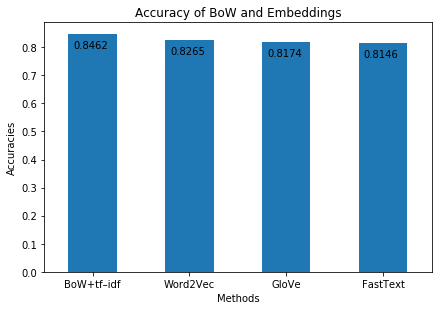

In [32]:
df_accuracies = pd.Series([accuracy_bow, accuracy_word2vec, accuracy_fasttext, accuracy_glove], 
                          ['BoW+tf–idf', 'Word2Vec', 'FastText', 'GloVe'])
df_accuracies = df_accuracies.sort_values(ascending=False)

# Draw the bar Plot from accuracies
df_accuracies.plot(x='Methods', y='Accuracy', kind='bar', rot=0)

# Show the plot
plt.tight_layout()
plt.title("Accuracy of BoW and Embeddings")
plt.xlabel('Methods')
plt.ylabel('Accuracies')
for i, v in enumerate(df_accuracies):
    plt.text(i-0.2, v-0.05, str(round(v,4)))
plt.show()